In [20]:
import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath('./loss_function.py'))))
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import scanpy as sc

from model import Encoder, Decoder, gene_act, FC
from loss_function import MMD_LOSS, maximum_mean_discrepancy
from utils import plot_train

In [21]:
def _nan2inf(x):
    return torch.where(torch.isnan(x), torch.zeros_like(x)+np.inf, x)

def _nan2zero(x):
    return torch.where(torch.isnan(x), torch.zeros_like(x), x)

def _nelem(x):
    nelem = torch.reduce_sum(torch.float(~torch.isnan(x), torch.float32))
    return torch.float(torch.where(torch.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return torch.divide(torch.reduce_sum(x), nelem)

class NB():
    def __init__(self, theta=None, masking=False, scope='nbinom_loss/',
                 scale_factor=1.0, debug=False):

        # for numerical stability
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.scope = scope
        self.masking = masking
        self.theta = theta

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        y_true = y_true.type(torch.float32)
        y_pred = y_pred.type(torch.float32) * scale_factor

        if self.masking:
            nelem = _nelem(y_true)
            y_true = _nan2zero(y_true)

        # Clip theta
        theta = torch.minimum(self.theta, torch.tensor(1e6))

        t1 = torch.lgamma(theta+eps) + torch.lgamma(y_true+1.0) - torch.lgamma(y_true+theta+eps)
        t2 = (theta+y_true) * torch.log(1.0 + (y_pred/(theta+eps))) + (y_true * (torch.log(theta+eps) - torch.log(y_pred+eps)))

        final = t1 + t2

        final = _nan2inf(final)

        if mean:
            if self.masking:
                final = torch.divide(torch.reduce_sum(final), nelem)
            else:
                final = torch.reduce_mean(final)

        return final  

class ZINB(NB):
    def __init__(self, pi, ridge_lambda=0.0, scope='zinb_loss/', **kwargs):
        super().__init__(scope=scope, **kwargs)
        self.pi = torch.tensor(pi)
        self.ridge_lambda = ridge_lambda

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        # reuse existing NB neg.log.lik.
        # mean is always False here, because everything is calculated
        # element-wise. we take the mean only in the end
        nb_case = super().loss(y_true, y_pred, mean=False) - torch.log(torch.tensor(1.0-self.pi+eps))

        y_true = y_true.type(torch.float32)
        y_pred = y_pred.type(torch.float32) * scale_factor
        theta = torch.minimum(self.theta, torch.tensor(1e6))

        zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
        zero_case = -torch.log(self.pi + ((1.0-self.pi)*zero_nb)+eps)
        result = torch.where(torch.less(y_true, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda*torch.square(self.pi)
        result += ridge

        if mean:
            if self.masking:
                result = _reduce_mean(result) 
            else:
                result = torch.mean(result)

        result = _nan2inf(result)

        return result

In [22]:
# Data
path_mtx = r"./data/mtx_0.mtx"
data_test = sc.read_mtx(path_mtx)
mtx_data = np.array(data_test.X.todense())

(238, 27943) (238, 5050)


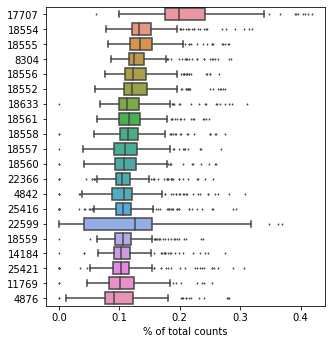

In [23]:
# PREVIEW
load_data = data_test.copy()
sc.pp.filter_genes(load_data, min_cells=50)
print(data_test.shape, load_data.shape)

sc.pl.highest_expr_genes(data_test, n_top=20)

In [24]:
batch_size = 32
all_data = np.array(load_data.X.todense())
random.seed(214)

m = len(all_data)
print(m)

train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

238


In [25]:
net_struc = [all_data.shape[1], 1024, 512, 256, 128, 64]

encoder = Encoder(features=net_struc)
decoder = Decoder(features=net_struc[1:][::-1])

# loss_fn = MMD_LOSS()
loss_fn = nn.MSELoss()

# Define Optimizer
lr = 0.0001

#Random seed
torch.manual_seed(0)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr, weight_decay=1e-05)

def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [26]:
class OutputLayer(nn.Module):
    def __init__(self, outputSize, lastHidden) -> None:
        super().__init__()
        self.output_size = outputSize
        self.last_hidden = lastHidden
        self.mean_layer = FC(features=[self.last_hidden, self.output_size])
        self.pi_layer = FC(features=[self.last_hidden, self.output_size])
        self.theta_layer = FC(features=[self.last_hidden, self.output_size])
        # self.zinb = ZINB()

    def forward(self, decodedData):
        Miu = self.mean_layer(decodedData)
        Pi = self.pi_layer(decodedData)
        Theta = self.theta_layer(decodedData)
        return Miu, Pi, Theta

output_layer = OutputLayer(net_struc[0], net_struc[1])

In [32]:
# Training
def train_epoch(encoder, decoder, dataloader, optimizer):
    encoder.train()
    decoder.train()
    output_layer.train()
    train_loss = 0.0
    for sc_data_batch in dataloader:
        # Encode
        encoded_data = encoder(sc_data_batch)
        # Decode
        decoded_data = decoder(encoded_data)

        # Compute params for DCA
        mean_param, pi_param, theta_param = output_layer(decoded_data)

        # Evaluate loss
        zinb = ZINB(pi_param, theta=theta_param)
        zinb_loss = (zinb.loss(mean_param, sc_data_batch))
        mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
        loss = zinb_loss * 0.5 + mmd_loss * 0.5

        # Backword 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item() != np.NaN:
            train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [28]:
# Testing func
def test_epoch(encoder, decoder, dataloader):
    encoder.eval()
    decoder.eval()
    output_layer.eval()
    test_loss = 0.0
    with torch.no_grad(): # Don't track gradients
        for sc_data_batch in dataloader:
            # Encode
            encoded_data = encoder(sc_data_batch)
            # Decode
            decoded_data = decoder(encoded_data)
            # Compute params for DCA
            mean_param, pi_param, theta_param = output_layer(decoded_data)

            zinb = ZINB(pi_param, theta=theta_param)

            zinb_loss = (zinb.loss(mean_param, sc_data_batch))
            mmd_loss = maximum_mean_discrepancy(mean_param, sc_data_batch)
            loss = zinb_loss * 0.5 + mmd_loss * 0.5
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)

C:\Users\91530\AppData\Local\Temp/ipykernel_51808/2308866896.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pi = torch.tensor(pi)
C:\Users\91530\AppData\Local\Temp/ipykernel_51808/2308866896.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nb_case = super().loss(y_true, y_pred, mean=False) - torch.log(torch.tensor(1.0-self.pi+eps))



 EPOCH 1/50 	 train loss inf 	 val loss 0.32340776920318604

 EPOCH 2/50 	 train loss inf 	 val loss 0.31943662961324054

 EPOCH 3/50 	 train loss inf 	 val loss 0.3160349329312642

 EPOCH 4/50 	 train loss inf 	 val loss 0.3117534319559733

 EPOCH 5/50 	 train loss inf 	 val loss 0.3067932228247325


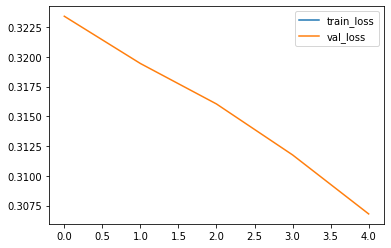


 EPOCH 6/50 	 train loss inf 	 val loss 0.3014561136563619

 EPOCH 7/50 	 train loss inf 	 val loss 0.2953374981880188

 EPOCH 8/50 	 train loss inf 	 val loss inf


KeyboardInterrupt: 

In [40]:
num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder, train_loader,optim)
   test_loss = test_epoch(encoder,decoder,test_loader)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(test_loss)
   if epoch and (epoch + 1) % 5 == 0:
      plot_train(diz_loss)